In [12]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import minimize

def read_files(files):
    data = []
    for f in files:
        data += [pd.read_csv(f, sep=',', skipinitialspace=True)]
    return data

In [13]:
def fit(f, par, x, y):
    """Аргументы:
    f - функция, которую мы хотим оптимизировать.
    params - начальное состояние параметров, можно просто передать нули,
    главное чтоб их было нужное количество
    x, y - точки, под которые подгоняем функцию
    """
    if len(x) != len(y):
        raise "Иксов должно быть столько же, сколько и игреков"
    def err(par, x_, y_):
        y1 = f(par, x_)
        return np.sum((y1-y_)**2)
    return minimize(err, [par], args=(x, y)).x[0]

In [39]:
# Давления в 1 п. лабы

P_lim = [69.45, 4304.46]
P_atm = 99.71 * 1e3

inv_P = [1 / P_lim[1] + i / 6 * (1 / P_lim[0] - 1 / P_lim[1]) for i in range(7)]
inv_P += [1 / P_atm + i / 4 * (1 / P_lim[1] - 1 / P_atm) for i in range(4)]
P = [1 / p for p in inv_P]
P.sort()
P

[69.45,
 83.0719363645837,
 103.34132342824749,
 136.694512232762,
 201.83695244139577,
 385.5933585713642,
 4304.46,
 5657.8637324185265,
 8252.654613598917,
 15243.64502645898,
 99710.0]

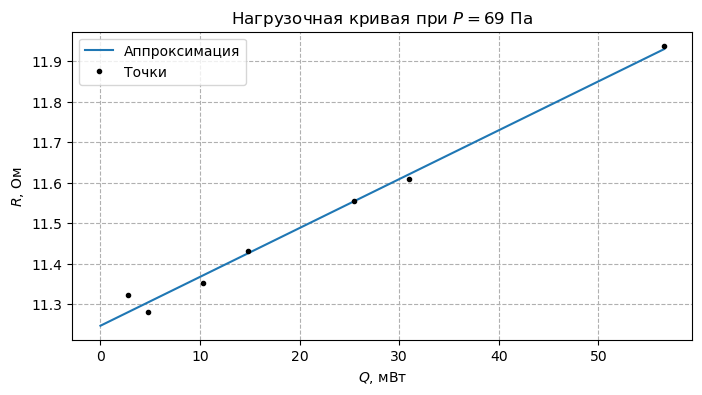

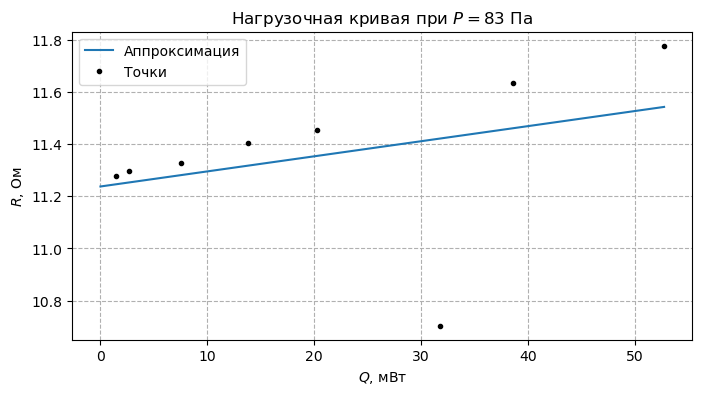

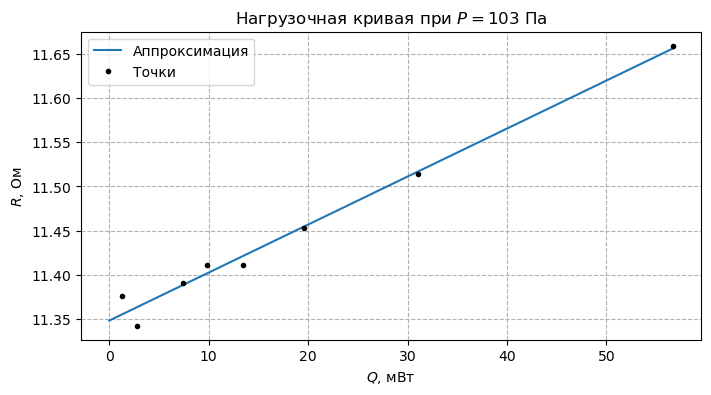

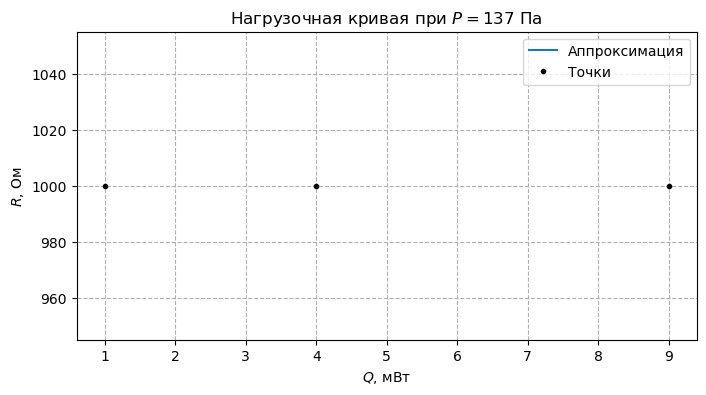

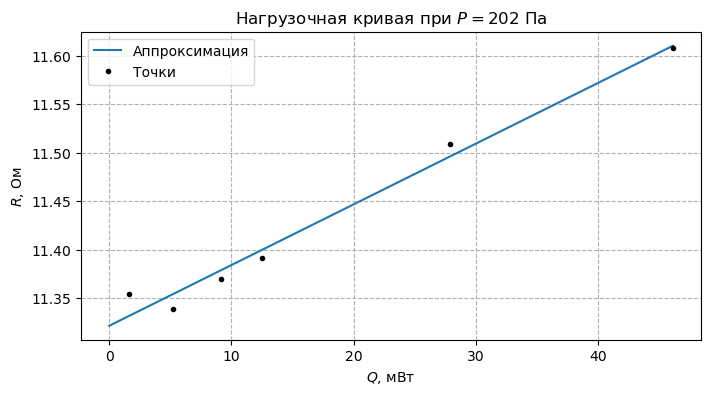

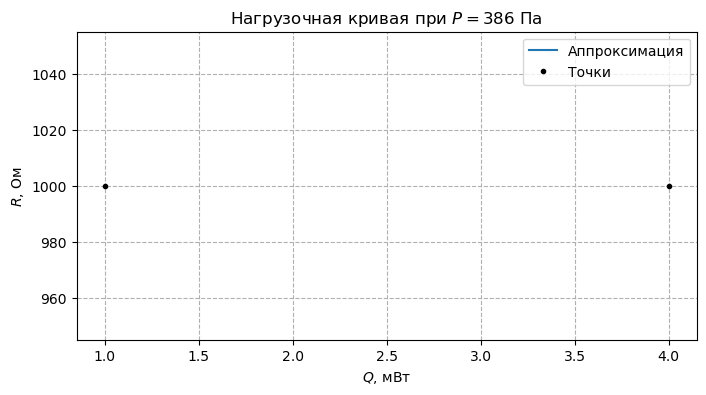

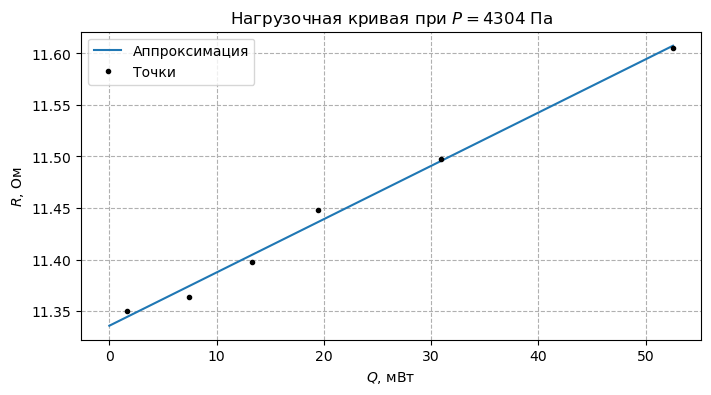

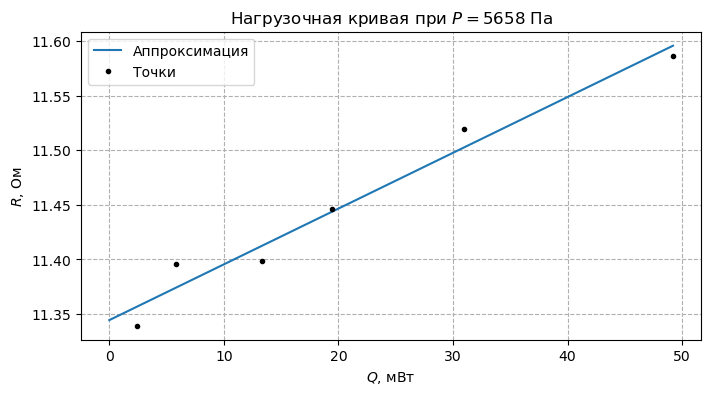

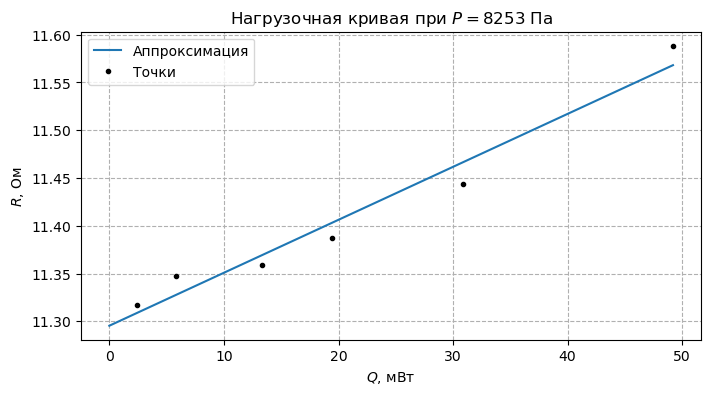

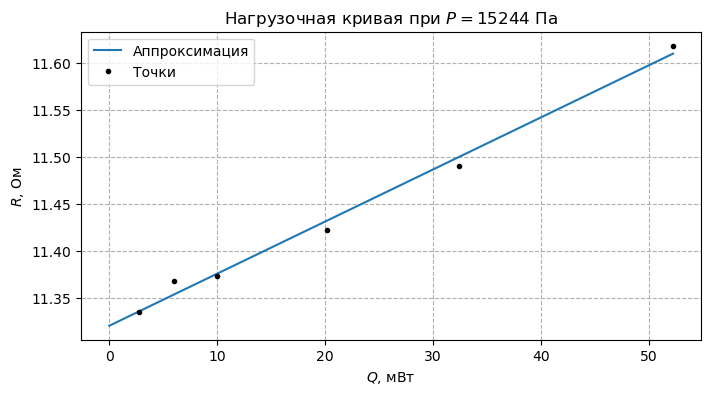

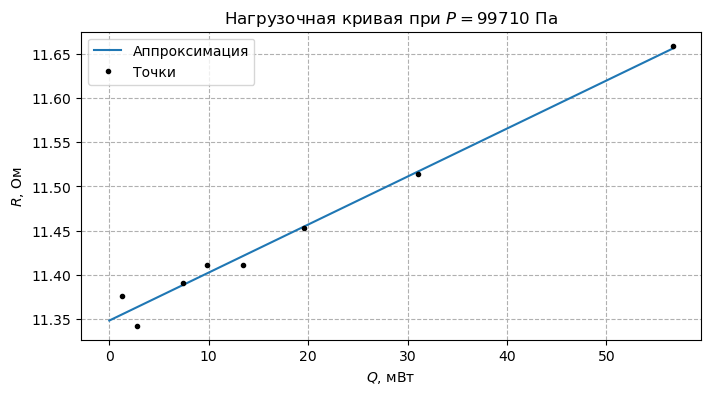

In [46]:
resistances = read_files([f'data/UI{p}.csv' for p in P])

cnt = 0
for resist in resistances:
    resist['R'] = resist['U(V)'] * 1e3 / resist['I(mA)']
    resist['Q'] = resist['U(V)'] * resist['I(mA)']

    plt.figure(figsize=(8, 4))
    plt.errorbar(resist['Q'], resist['R'], fmt='k.', label='Точки')
    [a, b] = np.polyfit(resist['Q'], resist['R'], deg=1)
    x_ax = np.linspace(0, max(resist['Q']), 1000)

    plt.plot(x_ax, a * x_ax + b, label='Аппроксимация')

    plt.xlabel('$Q$, мВт')
    plt.ylabel('$R$, Ом')
    plt.title(f'Нагрузочная кривая при $P = {P[cnt]:.0f}$ Па')
    plt.grid(linestyle='--')
    plt.legend()
    plt.savefig(f'graphs/RQ{P[cnt]}.pdf')
    cnt += 1


In [23]:
R_k = b
R_k

11.348375455934322

In [24]:
ALPHA = 3.92e-3
T_K = 27.1

R_0 = R_k / (1 + ALPHA * T_K)
R_0

10.258585410595897

In [25]:
DELTA_T_MAX = 30
R_MAX = R_0 * (1 + ALPHA * (T_K + DELTA_T_MAX))
R_MAX

12.554785100220398